In [75]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import json
config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

lr = 0.0005
max_epoch = 30000
dset='nsdsyn'
roi_list = ['V1','V2','V3']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']

# NSD 
## model

In [6]:
pt_file_list = []
dset = 'nsdsyn'
for subj, roi in itertools.product(nsd_subj_list, roi_list[:1]):
    file_name = os.path.join(results_dir, dset, f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-s_dset-{dset}_vs-pRFsize.csv'))
real_df = pd.merge(nsd_params, precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
real_df['bootstrap'] = 'real'

## Load in bootstraps

In [3]:
pt_file_list = []
dset = 'nsdsyn'
n_bootstrap = 100
for subj, roi in itertools.product(nsd_subj_list, roi_list[:1]):
    for i in range(n_bootstrap):
        file_name = os.path.join(results_dir, dset, 'bootstraps', f'bootstrap-{i}_model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
        pt_file_list.append(file_name)
bootstrap_params = model.load_all_models(pt_file_list, *ARGS_2D+['bootstrap'])

## organize dataframes

In [7]:
param_cols = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']

# Melt bootstrap data to long format
boot_melted = bootstrap_params.melt(id_vars=['bootstrap','sub'], 
                                    value_vars=param_cols,
                                    var_name='parameter', value_name='value')

# Melt real data
real_melted = real_df.melt(id_vars=['sub','bootstrap'], 
                            value_vars=param_cols, 
                            var_name='parameter', 
                            value_name='value')


## Sanity check: bootstrap histogram

In [28]:
sns.set_style('ticks')
sns.set_context('notebook')

for roi in roi_list[:1]:
    for subj in nsd_subj_list:

        v1_df = nsd_df.query('sub == @subj & vroinames == @roi')
        v1_bootstrap_df = bootstrap_params.query('sub == @subj & vroinames == @roi')

        # v1_df = v1_df.copy()
        # v1_df['bootstrap'] = 999 
        # sample_df = pd.concat((v1_df, v1_bootstrap_df), axis=0)

        # Melt bootstrap data to long format
        boot_melted = v1_bootstrap_df.melt(id_vars=['bootstrap'], value_vars=param_cols,
                                var_name='parameter', value_name='value')
        # Melt real data
        real_melted = v1_df[param_cols].melt(value_vars=param_cols, var_name='parameter', value_name='value')
        
        # plot
        g = sns.FacetGrid(data=boot_melted, height=4, aspect=1.5,
                    col='parameter', col_wrap=3, sharey=False, sharex=False)
        g.map(sns.histplot, 'value', color='gray', stat='probability', bins=20)
        for ax, param in zip(g.axes.flat, param_cols):
            real_val = real_melted.query('parameter == @param')['value'].values
            if len(real_val) > 0:
                ax.axvline(real_val[0], color='red', linestyle='--', label='Real\nvalue')
                ax.set_title(f'{param}')
            g.axes[0].legend()

        g.fig.suptitle(f'{subj}', fontsize=12, fontweight='bold')
        fig_path = os.path.join(fig_dir, 'bootstraps', f'bootstrap_param_hist_{subj}_V1.png')
        plt.tight_layout()
        utils.save_fig(fig_path)
        plt.close(g.fig)
    

In [8]:
# Compute 16th and 84th percentiles for each group
ci_df = boot_melted.groupby(['sub', 'parameter'])['value'].quantile([0.16, 0.84]).unstack(level=-1).reset_index()
ci_df = ci_df.rename(columns={0.16: 'ci_low_16', 0.84: 'ci_high_84'})


In [11]:
real_melted

,sub,bootstrap,parameter,value
0,subj01,real,sigma,2.543468
1,subj02,real,sigma,1.939601
2,subj03,real,sigma,2.354656
3,subj04,real,sigma,1.942886
4,subj05,real,sigma,2.365275
...,...,...,...,...
67,subj04,real,A_2,-0.017066
68,subj05,real,A_2,-0.002528
69,subj06,real,A_2,-0.026395
70,subj07,real,A_2,0.011840


In [12]:
plot_df =pd.merge(real_melted[['sub','parameter','value']], ci_df, on=['sub', 'parameter'])

# Compute error bar length
plot_df['yerr_lower'] = plot_df['value'] - plot_df['ci_low_16']
plot_df['yerr_upper'] = plot_df['ci_high_84'] - plot_df['value']
#yerr = np.vstack([plot_df['yerr_lower'], plot_df['yerr_upper']])
plot_df

,sub,parameter,value,ci_low_16,ci_high_84,yerr_lower,yerr_upper
0,subj01,sigma,2.543468,2.395660,2.669181,0.147809,0.125713
1,subj02,sigma,1.939601,1.904160,2.094369,0.035441,0.154768
2,subj03,sigma,2.354656,2.130229,2.458407,0.224427,0.103752
3,subj04,sigma,1.942886,1.858707,2.003816,0.084179,0.060931
4,subj05,sigma,2.365275,2.172823,2.394941,0.192452,0.029666
...,...,...,...,...,...,...,...
67,subj04,A_2,-0.017066,-0.035295,-0.014718,0.018229,0.002348
68,subj05,A_2,-0.002528,-0.021880,-0.008748,0.019353,-0.006221
69,subj06,A_2,-0.026395,-0.041544,-0.025422,0.015149,0.000973
70,subj07,A_2,0.011840,-0.015151,-0.003643,0.026991,-0.015483


In [105]:
plot_df =pd.merge(real_melted, ci_df, on=['sub', 'parameter'])

# Compute error bar length
plot_df['yerr_lower'] = plot_df['value'] - plot_df['ci_low_16']
plot_df['yerr_upper'] = plot_df['ci_high_84'] - plot_df['value']
tmp = plot_df.query('sub == "subj01"')

In [59]:
plot_df

,sub,parameter,value,ci_low_16,ci_high_84,yerr_lower,yerr_upper
0,subj01,sigma,2.543468,2.395660,2.669181,0.147809,0.125713
1,subj02,sigma,1.939601,1.904160,2.094369,0.035441,0.154768
2,subj03,sigma,2.354656,2.130229,2.458407,0.224427,0.103752
3,subj04,sigma,1.942886,1.858707,2.003816,0.084179,0.060931
4,subj05,sigma,2.365275,2.172823,2.394941,0.192452,0.029666
...,...,...,...,...,...,...,...
67,subj04,A_2,-0.017066,-0.035295,-0.014718,0.018229,0.002348
68,subj05,A_2,-0.002528,-0.021880,-0.008748,0.019353,-0.006221
69,subj06,A_2,-0.026395,-0.041544,-0.025422,0.015149,0.000973
70,subj07,A_2,0.011840,-0.015151,-0.003643,0.026991,-0.015483


In [29]:
PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']
weighted_mean_df =utils.calculate_weighted_mean(real_df, PARAMS_2D, 'precision')

In [63]:
weighted_mean_df['sub'] = 'weighted mean'
weighted_mean_df_melted = pd.melt(weighted_mean_df.drop(columns=['vroinames']), id_vars=['sub'], 
var_name='parameter', value_name='value')

plot_df =pd.concat((plot_df, weighted_mean_df_melted))

In [ ]:
ylim_list = [(1, 3), (0, 0.43), (-0.2, 0.2),(-0.1,0.1), (-0.4, 0.4)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.4,-0.2,0,0.2,0.4]]

params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1','A_2'], ['p_3','p_4']]

vis2D.plot_individual_parameters(plot_df,
                                 weighted_mean_df=weighted_mean_df,
                                 x='parameter',
                                 y='value', 
                                 hue='sub', 
                                 hue_order=nsd_subj_list + ['weighted mean'], 
                                 params_list=params_list, 
                                 ylim_list=ylim_list, 
                                 yticks_list=yticks_list,
                                 save_path=os.path.join(config['FIG_DIR'], 'sfp_model', 'results_2D', 'all', 'individual-parameters-V1.svg'))

In [81]:
param_rows

,sub,bootstrap,parameter,value,ci_low_16,ci_high_84,yerr_lower,yerr_upper
0,subj01,real,sigma,2.543468,2.395660,2.669181,0.147809,0.125713
1,subj02,real,sigma,1.939601,1.904160,2.094369,0.035441,0.154768
2,subj03,real,sigma,2.354656,2.130229,2.458407,0.224427,0.103752
3,subj04,real,sigma,1.942886,1.858707,2.003816,0.084179,0.060931
4,subj05,real,sigma,2.365275,2.172823,2.394941,0.192452,0.029666
5,subj06,real,sigma,2.161492,2.016833,2.279199,0.144659,0.117707
6,subj07,real,sigma,2.069652,1.901536,2.113847,0.168116,0.044195
7,subj08,real,sigma,2.345951,2.185500,2.689057,0.160451,0.343106


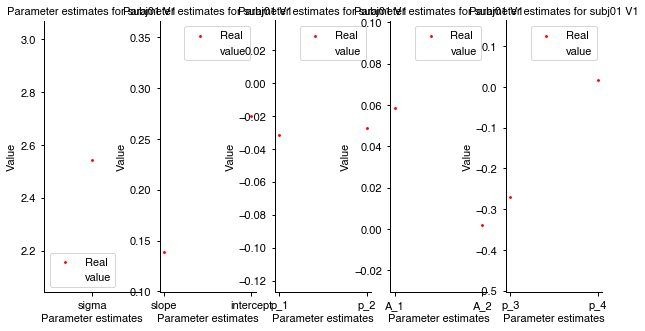

In [7]:
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=len(params_list))

for i, param in enumerate(params_list):
    ax = axes[i]
    ax = sns.scatterplot(ax=ax, data=real_melted.query('parameter in @param'), 
                         x='parameter', y='value', color='red', s=10, zorder=10, label='Real')
    ax.errorbar(data=boot_melted.query('parameter in @param'),
                 x='parameter', y='value', linestyle='', color='red')
    ax.set_xlabel('Parameter estimates')
    ax.set_ylabel('Value')
    ax.set_title('Parameter estimates for subj01 V1')
    ax.legend()

ax.set_xlabel('Parameter estimates')
ax.set_ylabel('Value')
ax.set_title('Parameter estimates for subj01 V1')
ax.legend()
plt.show()


In [ ]:
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
ylim_list = [(1, 3), (0, 0.42), (-0.2, 0.2),(-0.1, 0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]
vis2D.make_param_summary_fig(tmp, hue='sub', hue_order=nsd_subj_list, 
                             pal=sns.color_palette('tab10'), scale=0.8, 
                             width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                             params_list=params_list)

# Plot parameter estimates

(<Figure size 1857.6x324 with 5 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

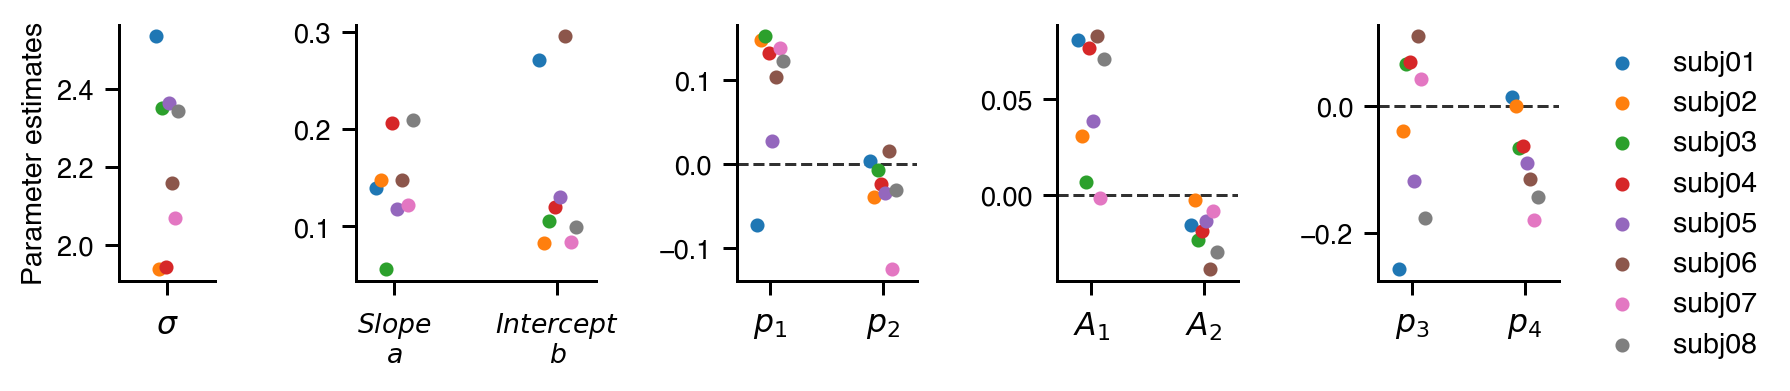

In [ ]:
tmp = final_df.query('dset_type == "NSD V1"')
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
ylim_list = [(1, 3), (0, 0.42), (-0.2, 0.2),(-0.1, 0.1), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.1,0,0.1], [-0.2,0,0.2]]
vis2D.make_param_summary_fig(tmp, hue='sub', hue_order=nsd_subj_list, 
                             pal=sns.color_palette('tab10'), scale=0.8, 
                             width_ratios=(0.8,2,1.5,1.5,1.5), fig_size=(8.6, 1.5),
                             params_list=params_list)